# **Malicious URL Detection**

## **Importing Libraries**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import re
from wordcloud import WordCloud
from urllib.parse import urlparse
from googlesearch import search
import pickle as pk

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Bidirectional, LSTM, BatchNormalization, Embedding

## **Loading the data**

dataset link -- https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data

In [6]:
data = pd.read_csv("Dataset\malicious_phish.csv")
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## **Data cleaning & EDA**

### checking different classes

In [8]:
print(data['type'].unique())

['phishing' 'benign' 'defacement' 'malware']


In [9]:
data["type"].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='type'>

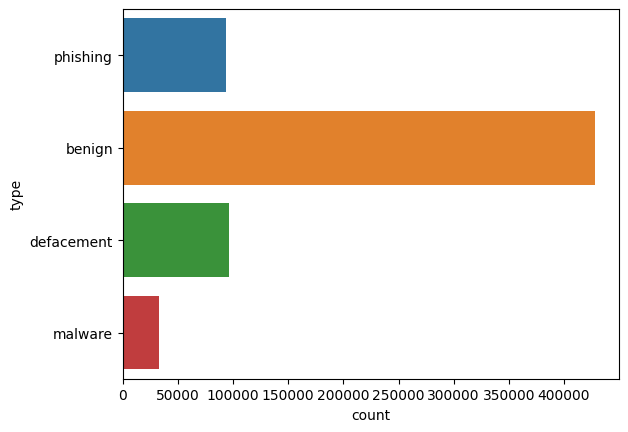

In [10]:
sns.countplot(data=data, y='type', hue='type')

In [36]:
data.type.value_counts()

type
benign        428057
defacement     94587
phishing       94074
malware        22206
Name: count, dtype: int64

### checking Null values

In [11]:
data.isna().sum()

url     0
type    0
dtype: int64

### Checking duplicate values

In [12]:
data.duplicated().sum()

10066

### Removing duplicate values

In [13]:
data.drop_duplicates(keep=False, inplace=True)
data.duplicated().sum()

0

### **Plotting WordCloud**

In [14]:
df_bengin = data[data['type'] == 'benign']
df_malware = data[data['type'] == 'malware']
df_defacement = data[data['type'] == 'defacement']
df_phishing = data[data['type'] == 'phishing']

##### Malware URLs

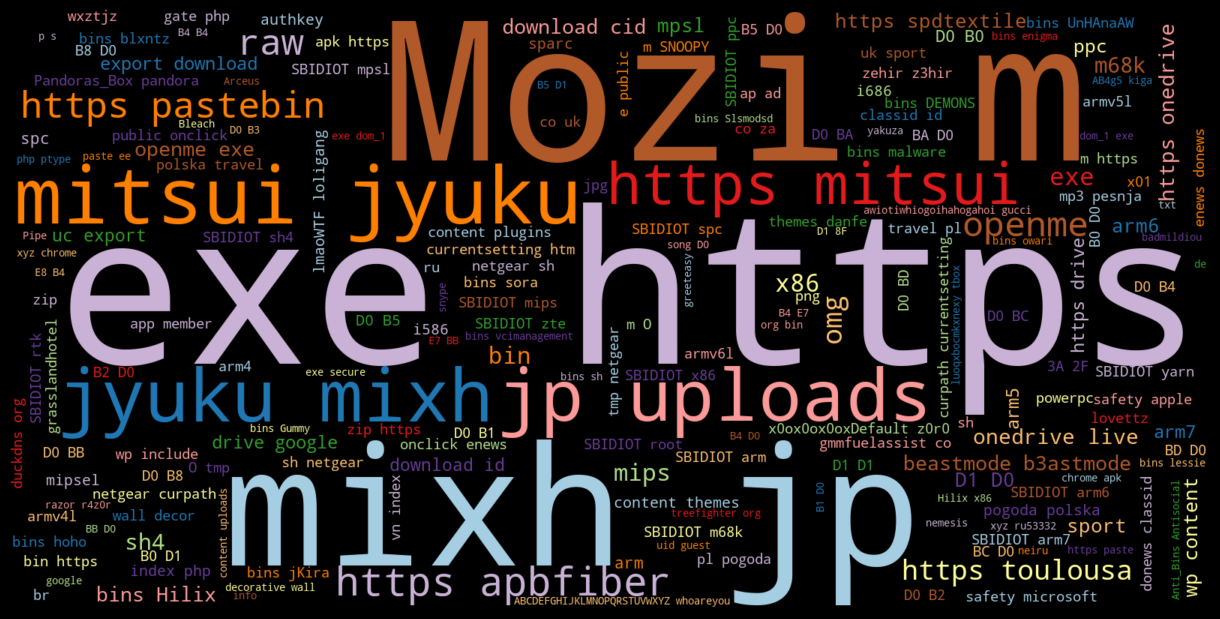

In [15]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Benign URLs

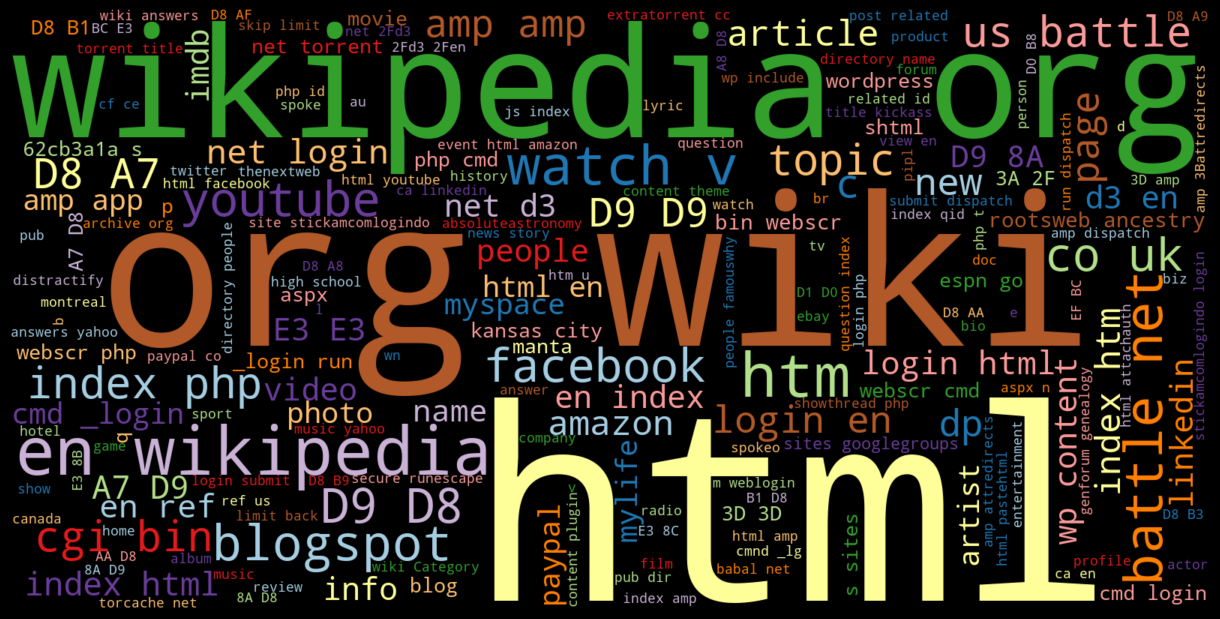

In [16]:
benign_url = " ".join(i for i in df_bengin.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Phishing URLs

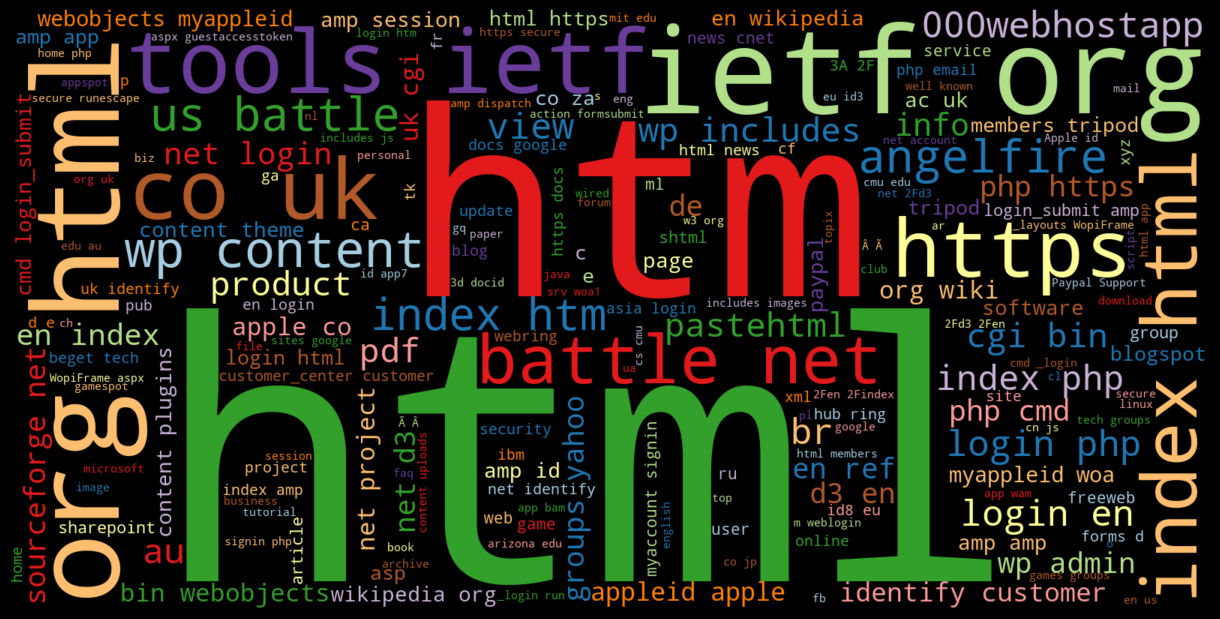

In [17]:
phishing_url = " ".join(i for i in df_phishing.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phishing_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Defacement URLs

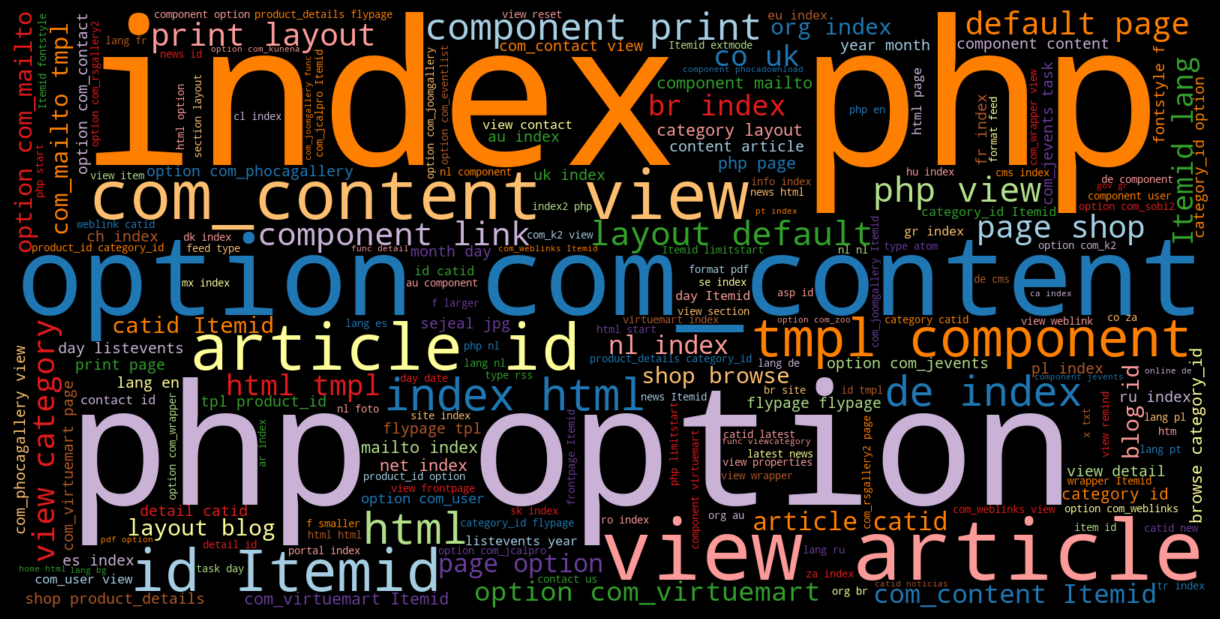

In [18]:
defacement_url = " ".join(i for i in df_defacement.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(defacement_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## **Feature Engineering**

### Checking if the domain contains the IP

In [19]:
def having_ip_address(url):
        match = re.search(
        # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        # IPv4 in hexadecimal
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' 
        # Ipv6
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  
        
        if match:
            return 1
        else:
            return 0
        

data['use_of_ip'] = data['url'].apply(lambda i: having_ip_address(i))

### Checking if the url is abnormal

In [20]:
def abnormal_url(url):
        hostname = urlparse(url).hostname
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
        else:
            return 0
          

data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

### Checking the URL with google

In [21]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0

data['google_index'] = data['url'].apply(lambda i: google_index(i))

### Counting number of dots in url

In [22]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

data['count'] = data['url'].apply(lambda i: count_dot(i))

In [23]:
data.head()

,url,type,use_of_ip,abnormal_url,google_index,count
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


## **Label Encodeing**

In [24]:
l = LabelEncoder()
data["label"] = l.fit_transform(data["type"])
data["label"].value_counts()

label
0    428057
1     94587
3     94074
2     22206
Name: count, dtype: int64

In [32]:
print(l.classes_)

['benign' 'defacement' 'malware' 'phishing']


## **Splitting the data**

### Features and Target split

In [25]:
X = data[['use_of_ip','abnormal_url','count']]
y = data.label

### Vectorizer

In [26]:
vectorizer = TfidfVectorizer(analyzer='char', lowercase=False)
X = vectorizer.fit_transform(data['url'])

In [40]:
pk.dump(vectorizer,open('vecotrizer.pkl','wb'))

### Train-Validate-Test split

In [27]:
# First, get 80% train and 20% test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=42)

# Second, get 80% train_1 for training and 20% val for validation with epochs
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,shuffle=True, random_state=42)

In [28]:
print(f"X_train: {X_train.shape}")

X_train: (511139, 333)


In [29]:
print(f"Train X size: {X_train_1.shape}")
print(f"validation X size: {X_val.shape}")
print(f"Test X size: {X_test.shape}")

Train X size: (408911, 333)
validation X size: (102228, 333)
Test X size: (127785, 333)


In [30]:
print(f"Train Y size: {y_train_1.shape}")
print(f"validation Y size: {y_val.shape}")
print(f"Test Y size: {y_test.shape}")

Train Y size: (408911,)
validation Y size: (102228,)
Test Y size: (127785,)


## **Model Building**

### RandomForest

In [31]:
RM = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
# training random forest model
RM.fit(X_train_1,y_train_1)
# predicting the output
y_pred1 = RM.predict(X_test)

In [33]:
y_pred1

array([0, 0, 1, ..., 0, 1, 3])

In [34]:
cm1 = confusion_matrix(y_test, y_pred1)
print(cm1)

[[84728    53     2   829]
 [  319 18517     0    81]
 [  138    78  3886   339]
 [ 3452   785    32 14546]]


In [38]:
pk.dump(RM,open('RF_model.pkl','wb'))

### DecisionTree

In [35]:
DT = DecisionTreeClassifier(criterion = 'entropy', random_state=22)
# training decisionTree model
DT.fit(X_train_1, y_train_1)
# predicting the output
y_pred2 = DT.predict(X_test)

In [33]:
y_pred2

array([0, 0, 3, ..., 0, 1, 3])

In [34]:
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)

[[82328   218    74  2992]
 [  207 17950    64   696]
 [   61    89  3949   342]
 [ 3029   765   400 14621]]


### Evaluation

In [35]:
classifiers = [y_pred1, y_pred2]
model_names = ['DecisionTreeClassifier', 'RandomForestClassifier']

# Create a dictionary to map model names to their respective predictions
classifier_map = dict(zip(model_names, classifiers))

# Now you can use this dictionary to iterate over each model name and its predictions
for model_name, y_pred in classifier_map.items():
    accuracy = accuracy_score(y_test, y_pred) 
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred) 
    
    print(f"\nMetrics for Model '{model_name}':")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1score}")
    print(f"Classification Report:\n{class_report}")


Metrics for Model 'DecisionTreeClassifier':
Accuracy: 0.9522009625542904
Precision: 0.951531096553588
Recall: 0.9522009625542904
F1-score: 0.9505682284407232
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     85612
           1       0.95      0.98      0.97     18917
           2       0.99      0.88      0.93      4441
           3       0.92      0.77      0.84     18815

    accuracy                           0.95    127785
   macro avg       0.96      0.90      0.93    127785
weighted avg       0.95      0.95      0.95    127785


Metrics for Model 'RandomForestClassifier':
Accuracy: 0.930062213874868
Precision: 0.9298782896648248
Recall: 0.930062213874868
F1-score: 0.9299661569136979
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     85612
           1       0.94      0.95      0.95     18917
           2       0.88      0.89      

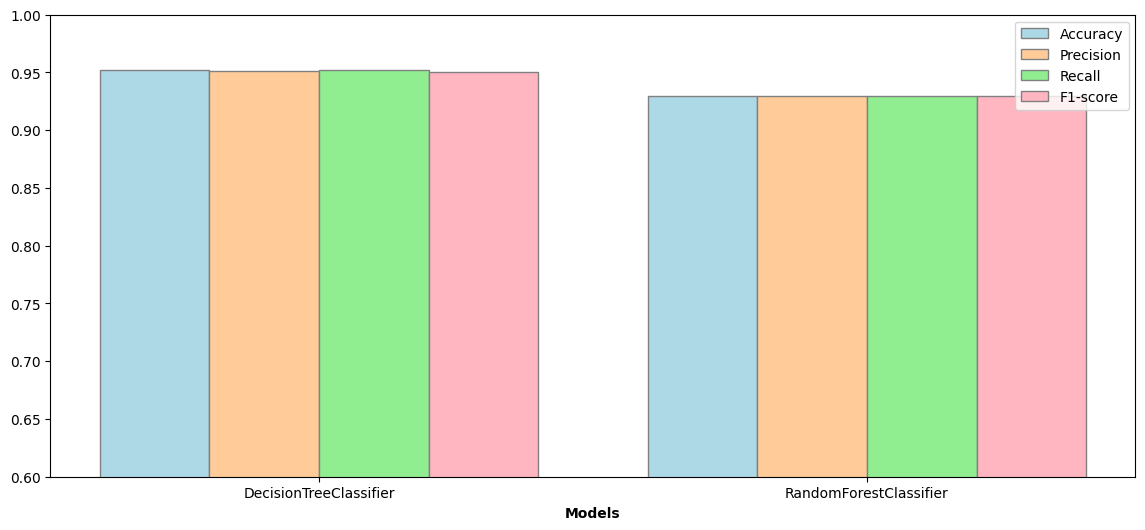

In [36]:
# Initialize data for the bar chart
models = list(classifier_map.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Calculate metric scores for each model
metric_scores = {}
for metric in metrics:
    metric_scores[metric] = [accuracy_score(y_test, classifier_map[model_name]) if metric == 'Accuracy'
                             else precision_score(y_test, classifier_map[model_name], average='weighted') if metric == 'Precision'
                             else recall_score(y_test, classifier_map[model_name], average='weighted') if metric == 'Recall'
                             else f1_score(y_test, classifier_map[model_name], average='weighted') for model_name in models]

# Set width of bars
bar_width = 0.2

# Set position of bars on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(14, 6))

# Define light colors
colors = ['#add8e6', '#ffcc99', '#90ee90', '#ffb6c1']

# Plotting the bars
plt.bar(r1, metric_scores['Accuracy'], color=colors[0], width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, metric_scores['Precision'], color=colors[1], width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, metric_scores['Recall'], color=colors[2], width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, metric_scores['F1-score'], color=colors[3], width=bar_width, edgecolor='grey', label='F1-score')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(models))], models)

# Set y-axis limits
plt.ylim(0.6, 1.0)

# Add a legend and show the plot
plt.legend()
plt.show()

## **DeepLearning Model**

### Model Building

In [37]:
model = Sequential()
model.add(Embedding(input_dim=X_train_1.shape[1], output_dim=128))
model.add(Bidirectional(tf.keras.layers.LSTM(128)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Traininig the model

In [39]:
model.fit(X_train_1,y_train_1,epochs=5,batch_size=200,validation_data=(X_val,y_val),verbose=1)

Epoch 1/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 4014s 2s/step - accuracy: 0.6497 - loss: 1.0279 - val_accuracy: 0.6700 - val_loss: 0.9500
Epoch 2/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 3596s 2s/step - accuracy: 0.6693 - loss: 0.9598 - val_accuracy: 0.6700 - val_loss: 0.9555
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 3311s 2s/step - accuracy: 0.6697 - loss: 0.9570 - val_accuracy: 0.6700 - val_loss: 0.9639
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 6267s 3s/step - accuracy: 0.6688 - loss: 0.9562 - val_accuracy: 0.6700 - val_loss: 0.9520
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 3446s 2s/step - accuracy: 0.6705 - loss: 0.9513 - val_accuracy: 0.6700 - val_loss: 0.9515


### Saving the model

In [40]:
model.save('neural_network.h5')

In [52]:
model.evaluate(X_test,y_test)

3994/3994 ━━━━━━━━━━━━━━━━━━━━ 453s 113ms/step - accuracy: 0.6725 - loss: 0.9485


[0.9514604210853577, 0.6699690818786621]

### predicting the output

In [67]:
yp=model.predict(X_test)

3994/3994 ━━━━━━━━━━━━━━━━━━━━ 445s 111ms/step


In [68]:
yp

array([[0.6513883 , 0.16464609, 0.03070533, 0.15326023],
       [0.6513883 , 0.16464609, 0.03070533, 0.15326023],
       [0.6513883 , 0.16464609, 0.03070533, 0.15326023],
       ...,
       [0.6513883 , 0.1646461 , 0.03070534, 0.15326023],
       [0.6513883 , 0.1646461 , 0.03070534, 0.15326023],
       [0.6513883 , 0.1646461 , 0.03070534, 0.15326023]], dtype=float32)

In [84]:
yp1=np.argmax(yp,1)

In [85]:
yp1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Evaluation 

In [86]:
cm=confusion_matrix(y_test,yp1)
cm

array([[85612,     0,     0,     0],
       [18917,     0,     0,     0],
       [ 4441,     0,     0,     0],
       [18815,     0,     0,     0]], dtype=int64)

In [88]:
cr=classification_report(y_test,yp1)
print(cr)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80     85612
           1       0.00      0.00      0.00     18917
           2       0.00      0.00      0.00      4441
           3       0.00      0.00      0.00     18815

    accuracy                           0.67    127785
   macro avg       0.17      0.25      0.20    127785
weighted avg       0.45      0.67      0.54    127785



C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
